# 001 Tests on how to extend the stellarflow system to a `tf-agents` compatible RL-Env.

Inspiration: https://towardsdatascience.com/creating-a-custom-environment-for-tensorflow-agent-tic-tac-toe-example-b66902f73059

In [34]:
## Imports
import numpy as np
import tensorflow as tf
import sys
from os.path import join
from os import getcwd
sys.path.append(join(getcwd(), "source"))

from importlib import reload  
import stellarflow as stf
stf = reload(stf)

## Settings
AU, ED = stf.System._AU, stf.System._ED

## Checking if GPU is used
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

In [35]:
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [36]:
class stfaEnv(py_environment.PyEnvironment):
    ## TODO: Implement mass / propellant consumtion
    def __init__(self, 
            mass: float,
            initial_location: np.ndarray, 
            initial_velocity: np.ndarray, 
            target_point:   np.ndarray,
            stfSystem:      stf.System,
            target_point_relative:      bool=False,
            target_point_relative_to:   int=None,
            reward_factor_boost:           float=1.0,
            reward_factor_target_distance: float=1.0):

        ## Additional Information for spacecraft
        self._m = mass
        self._m_hist = [mass]
        self._x = np.array(initial_location)
        self._y = np.array(initial_velocity)
        self._q = tf.constant(
            np.concatenate(
                [initial_location, initial_velocity], 
                axis=0
            ), 
            dtype=tf.float32
        )
        self._reward_factor_boost = reward_factor_boost
        self._reward_factor_target_distance = reward_factor_target_distance

        ## Target Location for rewards
        self._target = tf.constant(target_point, dtype=tf.float32)
        self._target_point_relative = target_point_relative
        if target_point_relative and target_point_relative_to is None:
            print("No target point reference object ('target_point_relative_to') provided, using first object of System.")
            self._target_point_relative_to = 0
        else:
            self._target_point_relative_to = target_point_relative_to

        ## Binding with stf.System:
        stfSystem._Q = tf.Variable(
            np.concatenate(
                [stfSystem._Q.numpy(), np.expand_dims(self._q, axis=0)], 
                axis=0), 
            dtype=tf.float32
        )
        stfSystem._Q_hist = tf.cast(tf.expand_dims(stfSystem._Q, axis=0), dtype=tf.float32)
        stfSystem._mask_reps, stfSystem._mask_len, stfSystem._mask = stfSystem._create_mask(stfSystem._Q.shape[0])
        stfSystem.masses = np.concatenate([stfSystem.masses, [mass]], axis=0) # Maybe put mass to 0
        stfSystem._M = stfSystem._reshape_masses(stfSystem.masses)
        self._sys = stfSystem

        ## State for max iterations
        self.n_iter = 0

        ## Providing for tfa-py_env
        #  TODO: Better values for minimum and maximum
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(3,), 
            dtype=np.float32, 
            minimum=-1e-31,
            maximum=1e-31,
            name="boost"
            )
        self._observation_spec = {
            "q-vector": array_spec.ArraySpec(self._sys._Q.shape, dtype=np.float32, name="q-vector"),
            "target": array_spec.ArraySpec((3,), dtype=np.float32, name="target")
        }
        self._state = self._sys._Q.numpy()
        self._initial_q = self._sys._Q
        self._episode_ended = False

        ## Variable for boost (Defy tf's-Error: "AssertionError: Called a function referencing variables which have been deleted.")
        self._current_boost = tf.Variable(
            tf.zeros_like(self._sys._Q, dtype=self._sys._Q.dtype)
        ) 


    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = {"q-vector": self._initial_q.numpy(), "target": self._target.numpy()}
        self._episode_ended = False
        self._sys._reset()
        return ts.restart(self._state)

    def _compute_target_distance(self):
        # TODO: Target point might need to be a function of steps, which needs to get hand designed for flexibility (e. g. Lagrange Points).
        if self._target_point_relative:
            target = self._target + self._sys._Q[self._target_point_relative_to, :3]
            return target - self._q[:3]
        else:
            return self._target - self._q[:3]

    # def _set_new_mass(self):
    #     # TODO: Effect of boosting (propellant consumption)
    #     self._m = self._m
    #     self._m_hist = np.concatenate([self._m_hist, [self._m]], axis=0)

    @tf.function
    def _accelerations_plus_boost(self, Q):
        return self._sys._acceleration(Q) + self._current_boost / self._m

    def _step(self, action: np.ndarray):
        self.n_iter += 1

        if self._episode_ended:
        # The last action ended the episode. Ignore the current action and start
        # a new episode.
            return self.reset()

        # Defining boost
        self._current_boost[-1, 3:].assign(
            tf.constant(action, dtype=self._current_boost.dtype)
        )
        
        # Performing a system step
        Q = self._sys._Q
        Q = self._sys._solver_rkf(Q, self._accelerations_plus_boost)
        self._sys._Q_hist = tf.concat([self._sys._Q_hist, [Q]], axis=0)
        self._sys._Q = Q
        self._q = Q[-1]
        # self._set_new_mass()
        self._state = {"q-vector": self._sys._Q.numpy(), "target": self._target.numpy()}

        # Bounding episode length
        if self._episode_ended or self.n_iter > 1000:
            reward = 0.0
            return ts.termination(self._state, reward)

        # Rewarding with boost length and distance to target
        else:
            distance = np.linalg.norm(self._compute_target_distance())
            target = self._sys._Q[self._target_point_relative_to]
            reward = -self._reward_factor_boost*np.linalg.norm(action) - self._reward_factor_target_distance*distance
            return ts.transition(
                self._state, reward=reward, discount=1.0
            )


## Testing

In [37]:
X = np.array([
    [0., 0.,    0.], # Sun 
    [1., 0.,    0.], # Earth
    [0., 1.524, 0.]  # Mars
])

V = np.array([
    [0.,           0., 0.],  # Sun 
    [0., 29290./AU*ED, 0.],  # Earth
    [27070./AU*ED, 0., 0.],  # Mars
])

M = np.array([
    1.,                # Sun
    3.0025e-6,         # Earth
    0.107 * 3.0025e-6  # Mars
])

# TODO: Smooth is way to high. Just for numerical stuff right now.
SEM_system = stf.System(X, V, M, smooth=1e-10)

In [38]:
env = stfaEnv(mass=1e-28, initial_location=[1.1, 0., 0.], initial_velocity=[0., 0.01, 0.], target_point=[2., 0., 0.], stfSystem=SEM_system)

In [39]:
fixed_boost = 1e-32*np.array([1., 0., 0.])

In [40]:
from tf_agents.policies import random_py_policy

time_step_spec = env.time_step_spec()
action_spec = env.action_spec()

rand_py_policy = random_py_policy.RandomPyPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

In [41]:
time_step = env._reset()
for _ in range(300):
    action = rand_py_policy.action(time_step).action
    time_step = env._step(action)

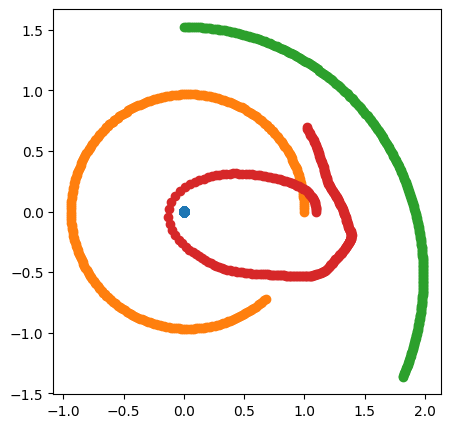

In [42]:
SEM_system.plot_history_2d()

In [43]:
utils.validate_py_environment(env, episodes=5)

## Trying to make the env a tf_env

In [44]:
del env
del SEM_system

In [45]:
SEM_system = stf.System(X, V, M)
env = stfaEnv(mass=1e-28, initial_location=[1.1, 0., 0.], initial_velocity=[0., 0.01, 0.], target_point=[2., 0., 0.], stfSystem=SEM_system)
tf_env = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'q-vector': TensorSpec(shape=(4, 6), dtype=tf.float32, name='q-vector'),
                 'target': TensorSpec(shape=(3,), dtype=tf.float32, name='target')},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-1.e-31, dtype=float32), maximum=array(1.e-31, dtype=float32))


In [46]:
from tf_agents.policies import random_tf_policy

time_step_spec = tf_env.time_step_spec()
action_spec    = tf_env.action_spec()

rand_tf_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec=time_step_spec,
    action_spec=action_spec
)

In [47]:
time_step = tf_env._reset()
for _ in range(300):
    action = rand_tf_policy.action(time_step).action
    time_step = tf_env._step([action])

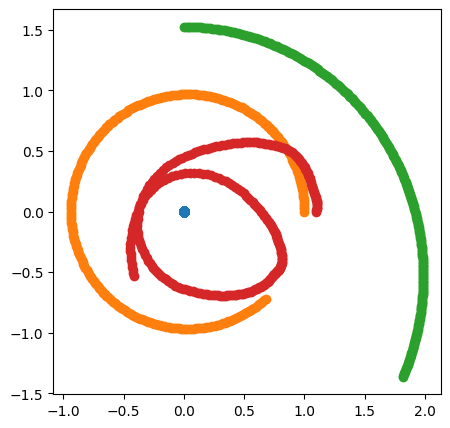

In [48]:
SEM_system.plot_history_2d()